In [183]:
import gzip
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random, heapq

In [184]:
##############################################################
########### reading data into a pandas dataframe #############
data = []
userRatings = defaultdict(list)

def readGz(f):
    for l in gzip.open(f):
        yield eval(l)
#training and validation 
for l in readGz("train.json.gz"):
    data.append(l)

print "total number of reviews: " , (len(data))
df = pd.DataFrame.from_dict(data)


validation_neg_pairs = set()
for l in open("pairs_Purchase_neg.txt",'r'):
    if l.startswith("reviewerID"):
        #header
        continue
    u,i = l.strip().split('-')
    validation_neg_pairs.add((u,i))
    
print(len(validation_neg_pairs))

total number of reviews:  200000
100000


## overview 
  Since the noise of the data is relatively high, I applied several filters/predictors by common user experience of purchansing. By setting threshold based on statistically analysis, we should obtain a good overal predictor.


  1  #### if an item is very poplular, it is highly possible to be purchased,
  
     Here I found the best thershold of popularity is 20.
     
 
  2  ####  if the item category strings match most strings of a user purchased item category,
          then highly likely to be purchased.
        
      Here I found the best threshold is  common strings > 5.
      OR   
      the Jaccard similarity is larger than 0.17
       

In [208]:
#setting up best f

common_strings = 5

Jac_threshold = 0.17

Popularity_threshold = 20


In [209]:
####################################################################
############  filter one  category instead of categoryID ########### 

df_item_cat_text = df[['categories','itemID']]
df_item_cat_text_uniq = df_item_cat_text.drop_duplicates(subset=['itemID'])
df_item_cat_text_uniq.set_index('itemID',inplace=True)

In [210]:
def flatten_cat_word_list(original_list):
    item_cat_set = set()
    for subcat in original_list:
        for cat_str in subcat:
            item_cat_set.add(cat_str)
    return item_cat_set

In [211]:
# flatten the category list into 1d list of an item to set of strings 
d_item_to_cat_text={}  # itemID to set of string

for idx,row in df_item_cat_text_uniq.iterrows():
    if idx not in d_item_to_cat_text:
        d_item_to_cat_text[idx] = set()
    d_item_to_cat_text[idx] |= flatten_cat_word_list(row['categories'])  

In [212]:
# flatten the dictionary of userId to text strings 
d_user_to_cat_text={}  # userID to set of strings

for idx, row in df.iterrows():
    userId,itemId = row['reviewerID'],row['itemID']
    
    if userId not in d_user_to_cat_text:
        d_user_to_cat_text[userId] = set()
        
    d_user_to_cat_text[userId] |= d_item_to_cat_text[itemId]

In [213]:
# check if the intersection of strings number is larger than 5
def similarity(item_cat_text,user_cat_text):
    return  len(item_cat_text & user_cat_text) > common_strings \
    or float(len(item_cat_text & user_cat_text)) / len(item_cat_text | user_cat_text)

In [214]:
def predictor_category(itemId, userId):

    # check itemId or userId do not exist
    if itemId not in d_item_to_cat_text or userId not in d_user_to_cat_text:
        return False 
   
    # run similarity to predict
    return similarity(d_item_to_cat_text[itemId],d_user_to_cat_text[userId]) > Jac_threshold


In [215]:
####################################################################
# ########### filter two ########### 
# filter the most popular items that have frequency higher than 20

items_freq = df['itemID'].value_counts()
plt_list = items_freq.value_counts().sort_index()

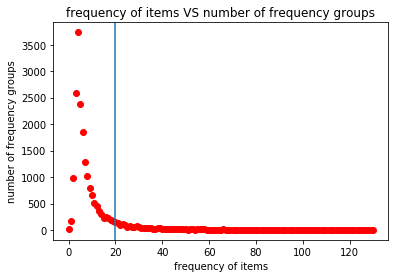

In [216]:

list_num = len(plt_list)

x = []
y = []
counter = 0
for item in (plt_list):
    x.append(counter)
    counter += 1
    y.append(item)
        
plt.title("frequency of items VS number of frequency groups")
plt.plot(x,y,'ro')
plt.xlabel("frequency of items")
plt.ylabel("number of frequency groups")

plt.axvline(x = Popularity_threshold)

In [217]:
# filter items by freq 
popular_items_freq = items_freq[items_freq > Popularity_threshold]
print "popular items: ", len(popular_items_freq)

popular items:  1742


In [218]:
##################################################################
#################### overall predictor ###########################

predictions = open("predictions_Purchase.txt", 'w')
predicted_true = 0
predicted_false = 0
lines = 0

for l in open("pairs_Purchase.txt"):
    lines += 1
    if l.startswith("reviewerID"):
        #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')

    # check the first predictor, if user purchased this category before 
    if i in popular_items_freq:
        predictions.write(u + '-' + i + ",1\n")
        predicted_true += 1
    else:
        if predictor_category(i, u):
            predictions.write(u + '-' + i + ",1\n")
            predicted_true += 1
        else:
            predictions.write(u + '-' + i + ",0\n")
            predicted_false += 1
            
print "number of line", lines
print "predicted_true", predicted_true
print "predicted_false: ", predicted_false

predictions.close()

number of line 28001
predicted_true 14262
predicted_false:  13738
